# 原子体系建模

In [1]:
import numpy as np
from scipy.spatial import distance
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  #3D plot

经验势$E_{\mathrm{emp}}=V(r_1,r_2)$和切割半径$R_{\mathrm{cut}}$表示函数

In [2]:
def emperical_potential(r1,r2,a=5,b=5):
    d = distance.euclidean(r1,r2)
    return a / (d ** 12) - b / (d ** 6)

In [3]:
def cutoff_func(r_ij,r_c = 4.0):  #f_c(R_ij)
    if r_ij > r_c:
        return 0
    else:
        return 0.5*(np.cos(np.pi * r_ij / r_c) + 1)

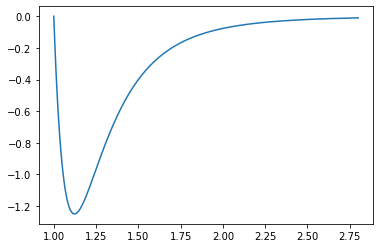

In [57]:
r = np.linspace(1.0,2.8,300)
value = np.array([emperical_potential(i,0) for i in r])
plt.plot(r,value)

原子类,包含原子坐标

In [5]:
class Atom():
    def __init__(self,coords):
        self.coords = coords
        self.individual_potential = 0
        self.g1_value = 0  #径向对称函数
        self.g2_value = 0  #径向对称函数
        self.g3_value = 0  #径向对称函数
    def individual_potential_cal(self,neighbors):
        for neighbor in neighbors:  #neighbors为相对距离列表
            self.individual_potential += 0.5 * emperical_potential(0,neighbor)
    def g1_cal(self,neighbors):
        for neighbor in neighbors:
            self.g1_value += cutoff_func(neighbor)
    def g2_cal(self,neighbors,eta = 0.4,r_s = 1.0):
        for neighbor in neighbors:
            self.g2_value += np.exp(-eta * (neighbor-r_s)**2)*cutoff_func(neighbor)
    def g3_cal(self,neighbors,kappa = 0.4):
        for neighbor in neighbors:
            self.g3_value += np.cos(kappa*neighbor)*cutoff_func(neighbor)

原子点集类,含维数、总势能、原子个数、坐标范围等参数,并有随机生成、输入列表生成、势能计算等方法

In [6]:
class AtomCollection():
    def __init__(self):
        """
        Args:
        coords_range: suppose (x, ...) is the coordinate of an atom while range is (a,b), then a<x<b, ...
        """
        self.atoms = []
        self.num = 0
        self.dimension = 0
        self.potential = 0
        self.coords_range=(-10,10)
        
    def random_generate(self,size,dimension=2):
        """generate a collection of atoms by using random numbers
        
        Args:
            size: the number of atoms in self.atoms
            dimension: 2 or 3
        """
        self.dimension = dimension
        temp_coords = np.random.uniform(self.coords_range[0],self.coords_range[1],
                                        dimension).tolist()  #1*dimension shape-like list
        self.num += 1
        self.atoms.append(Atom(temp_coords))
        while self.num < size:
            flag = True
            temp_coords = np.random.uniform(self.coords_range[0],self.coords_range[1],
                                            dimension).tolist()
            for atom in self.atoms:
                if distance.euclidean(atom.coords,temp_coords) < 1.0:  #太近了先不考虑
                    flag = False
                    break
            if flag is True:
                self.num +=1
                self.atoms.append(Atom(temp_coords))
                    
    def list_generate(self,coords_list):
        """generate a collection of atoms by using a given list
        
        Args:
            coords_list: shape like [[1,1,...],[2,2,...],...]
        """
        if coords_list == []:
            return
        for coords in coords_list:
            self.atoms.append(Atom(coords))
        self.num = len(coords_list)
        self.dimension = len(coords_list[0])
    
    def distance_cal(self,center):  #计算体系中其他所有原子和中心原子的相对距离
        dis = []
        for atom in self.atoms:
            if atom is not center:
                dis.append(distance.euclidean(atom.coords,center.coords))
        return dis
    
    def potential_cal(self):
        """calculate the total potential of the atom collection"""        
        for atom in self.atoms: #将每个原子的势能累加得到体系总势能
            self.potential += atom.individual_potential
        
    def plot_atoms(self):
        """plot all the atoms on one figure"""
        fig = plt.figure()
        
        if self.dimension == 2:
            fig.subplots_adjust(left=0, right=1, bottom=0, top=1)
            ax = fig.add_subplot(111, aspect='equal', autoscale_on=False,
                         xlim=self.coords_range, ylim=self.coords_range)
            for atom in self.atoms:
                ax.scatter(atom.coords[0],atom.coords[1], color = 'black')
            
        if self.dimension == 3:
            ax = Axes3D(fig)
            for atom in self.atoms:
                ax.scatter(atom.coords[0], atom.coords[1],atom.coords[2])
            ax.set_zlabel('Z', fontdict={'size': 15, 'color': 'black'})
            ax.set_ylabel('Y', fontdict={'size': 15, 'color': 'black'})
            ax.set_xlabel('X', fontdict={'size': 15, 'color': 'black'})
    
    def clear_collection(self):
        """erase all the coordinates"""
        self.atoms = []
        self.num = 0
        self.dimension = 0
        self.potential = 0
        self.coords_range=(-10,10)

# 神经网络训练

In [7]:
import tensorflow as tf

数据整理

In [8]:
def data_reshape(atom_collection_set):
    """reshape the collections, with output like [[g11,g12,g13],[g21,g22,g23],...] & [E1,E2,...]"""
    g_factors = []
    potentials = []
    for collection in atom_collection_set:
        for atom in collection.atoms:
            #g_factors.append([atom.g1_value,atom.g2_value])
            g_factors.append([atom.g1_value,atom.g2_value,atom.g3_value])
            potentials.append(atom.individual_potential)
            #print(atom.individual_potential)
            #print(len(potentials))
    return np.array(g_factors),np.array(potentials)

In [9]:
def get_batch(params,energies,batch_size):
    index = np.random.randint(0, len(energies), batch_size)
    return params[index],energies[index]

网络模型

In [16]:
class MLP(tf.keras.Model):
    def __init__(self):
        super().__init__()
        self.dense1_g1 = tf.keras.layers.Dense(units=35,activation = tf.nn.tanh)
        self.dense1_g2 = tf.keras.layers.Dense(units=35,activation = tf.nn.tanh)
        #self.dense1_g3 = tf.keras.layers.Dense(units=35,activation = tf.nn.tanh)
        self.dense2_g1 = tf.keras.layers.Dense(units=1)
        self.dense2_g2 = tf.keras.layers.Dense(units=1)
        #self.dense2_g3 = tf.keras.layers.Dense(units=1)

    def call(self, inputs):
        g1 = tf.slice(inputs,[0,0],[-1,1])  #tf.slice(data,begin,size)
        g1 = tf.reshape(g1,[-1,1])
        g2 = tf.slice(inputs,[0,1],[-1,1])
        g2 = tf.reshape(g2,[-1,1])
        #g3 = tf.slice(inputs,[0,2],[-1,1])
        #g3 = tf.reshape(g3,[-1,1])
        g1 = self.dense1_g1(g1)
        g1 = self.dense2_g1(g1)
        g2 = self.dense1_g2(g2)
        g2 = self.dense2_g2(g2)
        #g3 = self.dense1_g3(g3)
        #g3 = self.dense2_g3(g3)
        #output = g1 + g2 + g3
        output = g1 + g2
        return output

超参数hyperparameters

In [49]:
#network params
num_epoch = 1.0
batch_size = 10
rate = 0.0005

# params of configurations generation
atom_size = 50
configurations = 400
dim = 3

#test params
test_size = 20
test_atoms = 50

建数据集

In [52]:
config = 0
train_collections = []
r_ij = []
          
while config < configurations:
    temp = AtomCollection()
    temp.random_generate(size = atom_size,dimension = dim)
    for atom in temp.atoms:
        r_ij = []
        r_ij = temp.distance_cal(atom)
        atom.individual_potential_cal(r_ij)
        atom.g1_cal(r_ij)
        atom.g2_cal(r_ij)
        atom.g3_cal(r_ij)
        #print(len([i for i in r_ij if i < 4.0]))
    train_collections.append(temp)
    config += 1

In [53]:
g_factors,potentials = data_reshape(train_collections)
#len(train_collections)
#g_factors[:15]
potentials[:15]

array([-0.01863362, -0.00147641, -0.11761026, -0.00063209, -0.0014021 ,
       -0.00191996, -0.00654666, -0.00066373, -0.11424959, -0.08586999,
       -0.00162616, -0.03539739, -0.03019381, -0.09916851, -0.01167505])

训练及测试评估

In [54]:
#训练
model = MLP()
optimizer = tf.keras.optimizers.Adam(learning_rate=rate)
num_batches = int(len(potentials)//batch_size*num_epoch)

for batch_index in range(num_batches):
    X_train,y_train = get_batch(g_factors,potentials,batch_size)  #X: (batch_size,num_of_factors), y: (batch_size,)
    X_train = tf.convert_to_tensor(X_train,dtype = 'float32')
    with tf.GradientTape() as tape:
        y_pred = model(X_train)
        y_temp = tf.convert_to_tensor(y_train.reshape(-1,1),dtype = 'float32')
        loss = 0.5 * tf.reduce_sum(tf.square(y_pred - y_temp))
        if batch_index % 100 == 0:
            print("batch {}: loss {}".format(batch_index,loss.numpy()))
    grad = tape.gradient(loss,model.variables)  #model.variables直接调用模型变量
    optimizer.apply_gradients(grads_and_vars=zip(grad,model.variables))

batch 0: loss 0.05427857115864754
batch 100: loss 0.043002426624298096
batch 200: loss 0.003390443976968527
batch 300: loss 0.0021891146898269653
batch 400: loss 0.02803046628832817
batch 500: loss 0.001037684385664761
batch 600: loss 0.0021903901360929012
batch 700: loss 0.0058635869063436985
batch 800: loss 0.00862852018326521
batch 900: loss 0.0021946546621620655
batch 1000: loss 0.06812919676303864
batch 1100: loss 0.011598153039813042
batch 1200: loss 0.020327948033809662
batch 1300: loss 0.0047758170403540134
batch 1400: loss 0.0008714799769222736
batch 1500: loss 0.03561095520853996
batch 1600: loss 0.050026923418045044
batch 1700: loss 0.06650323420763016
batch 1800: loss 0.0011777550680562854
batch 1900: loss 0.02558363974094391


In [55]:
#建立几个原子集合看看效果
for size in range(test_size):
    atoms_sample = AtomCollection()
    atoms_sample.random_generate(size = test_atoms,dimension = dim)
    dist = []
    for atom in atoms_sample.atoms:
        dist = atoms_sample.distance_cal(atom)
        atom.individual_potential_cal(dist)
        atom.g1_cal(dist)
        atom.g2_cal(dist)
        atom.g3_cal(dist)
        #print(atom.individual_potential)
        dist = []
    atoms_sample.potential_cal()
    
    #测试评估
    X_sample,y_sample = data_reshape([atoms_sample])
    energy_pred = model.predict(X_sample)
    print("Theoretical Value:{},Predicted Value:{},Relative Error:{}".format(
        atoms_sample.potential,energy_pred.sum(),abs((atoms_sample.potential-energy_pred.sum())/atoms_sample.potential)))

Theoretical Value:-0.9477840737686053,Predicted Value:-1.002916932106018,Relative Error:0.058170273022411075
Theoretical Value:-2.5084776683116603,Predicted Value:-2.8143064975738525,Relative Error:0.12191809922231893
Theoretical Value:-2.139826198650186,Predicted Value:-2.5480904579162598,Relative Error:0.1907931866259088
Theoretical Value:-1.2453735249360673,Predicted Value:-2.0629076957702637,Relative Error:0.6564570022284402
Theoretical Value:-1.9488084931108034,Predicted Value:-3.055981159210205,Relative Error:0.5681279971907692
Theoretical Value:-0.8226576506322317,Predicted Value:-1.9229614734649658,Relative Error:1.337499045911899
Theoretical Value:-1.5404364006326379,Predicted Value:-2.1267876625061035,Relative Error:0.3806397080935367
Theoretical Value:-1.0377158254975938,Predicted Value:-1.4476255178451538,Relative Error:0.39501150726982964
Theoretical Value:-3.138030390799711,Predicted Value:-3.252650737762451,Relative Error:0.03652620678843389
Theoretical Value:-2.02588602